In [1]:
# v2.3
# Active Learning
# try different number of tested value
# early stop xgboost gold regressor

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import xgboost as xgb
import matplotlib
from sklearn.linear_model import LinearRegression

In [3]:
# Load All Dataset in One DataFrame
dataset = pd.concat([pd.read_csv('no_controls/plate_AL_{}_raw_yield_and_std.csv'.format(i)) for i in range(1,11)], ignore_index=True)
X = dataset.iloc[:, 0:11].values
y = dataset.iloc[:, 11].values

In [4]:
dataset

,nad,folinic_acid,coa,nucleo_mix,spermidin,pga,aa,trna,mg_gluta,camp,K_gluta,yield,yield_std
0,0.165,0.0204,0.078,0.75,0.3,9,0.45,0.02,1.2,0.375,40,0.0000,0.0131
1,0.330,0.0680,0.260,1.50,1.0,30,1.50,0.20,0.4,0.750,80,0.0000,0.0095
2,0.330,0.0680,0.260,0.15,1.0,30,1.50,0.20,4.0,0.750,80,0.0000,0.0770
3,0.330,0.0680,0.260,0.45,1.0,30,1.50,0.20,4.0,0.750,80,0.0000,0.0940
4,0.330,0.0680,0.260,1.50,1.0,30,0.15,0.20,4.0,0.750,80,0.0147,0.0233
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1012,0.330,0.0680,0.026,1.50,0.1,9,1.50,0.10,4.0,0.225,80,2.3193,0.1248
1013,0.330,0.0204,0.026,1.50,0.1,9,1.50,0.20,4.0,0.375,80,2.1215,0.2133
1014,0.330,0.0204,0.260,1.50,0.1,9,1.50,0.06,4.0,0.225,80,1.9952,0.1664
1015,0.330,0.0204,0.078,1.50,0.1,9,1.50,0.20,4.0,0.375,80,2.1736,0.0562


In [5]:
def boxplot(data, group_name, quantity, hue = None, title = '', point_size = 10):
    plt.style.use('seaborn-whitegrid')
    plt.style.use('seaborn-poster')
    # create a figure
    fig = plt.figure(figsize=(20,10))
    # Usual boxplot
    sns.boxplot(x=group_name, y=quantity, data=data)
    # Create a matplotlib colormap from the sns seagreen color palette
    cmap = sns.light_palette("PURPLE", reverse=False, as_cmap=True )
    # Normalize to the range of possible values from df["c"]
    norm = matplotlib.colors.Normalize(vmin=data[hue].min(), vmax=data[hue].max())
    # create a color dictionary (value in c : color from colormap) 
    colors = {}
    for cval, group in zip(data[hue], data[group_name]):
        norm = matplotlib.colors.Normalize(vmin=data[hue][data[group_name]==group].min(), vmax=data[hue][data[group_name]==group].max())
        colors.update({cval : cmap(norm(cval))})
    # plot the swarmplot with the colors dictionary as palette
    sns.swarmplot(x=group_name, y = quantity,  hue=hue, s=10, data = data, palette = colors)
    # remove the legend, because we want to set a colorbar instead
    plt.gca().legend_.remove()
    plt.title(title)
    plt.show()

In [7]:
# Define our GOLD STANDARD MODEL
gold_regressor = xgb.XGBRegressor(
objective = 'reg:squarederror',
n_estimators = 500,
learning_rate = 0.01,
max_depth = 6,
min_child_weight = 1,
subsample = 0.8)



# Validation Split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2)

# Training ...
gold_regressor.fit(X_train, y_train,eval_set=[(X_val, y_val)],eval_metric='mae', early_stopping_rounds=15, verbose=0)

# Predicting the Test set results
y_pred = gold_regressor.predict(X_test)

# Prediction Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
mae = mean_absolute_error(y_pred, y_test)
mse = mean_squared_error(y_pred, y_test)
r2 = r2_score(y_pred, y_test)
print('mse :',mse)
print('mae :',mae)
print('R2 :', r2)

mse : 0.022361377053259208
mae : 0.10678144456545513
R2 : 0.9610774967757413


In [18]:
## reconstruct the Paper plot
# Part 1: Reshape Dataset
# Load All Dataset in One DataFrame
box_data = []
for i in range(10):
    temp = pd.read_csv('no_controls/plate_AL_{}_raw_yield_and_std.csv'.format(i+1))
    temp['Step'] = 'Step_{}'.format(i+1)
    box_data.append(temp)
box_dataset = pd.concat(box_data, ignore_index=True)

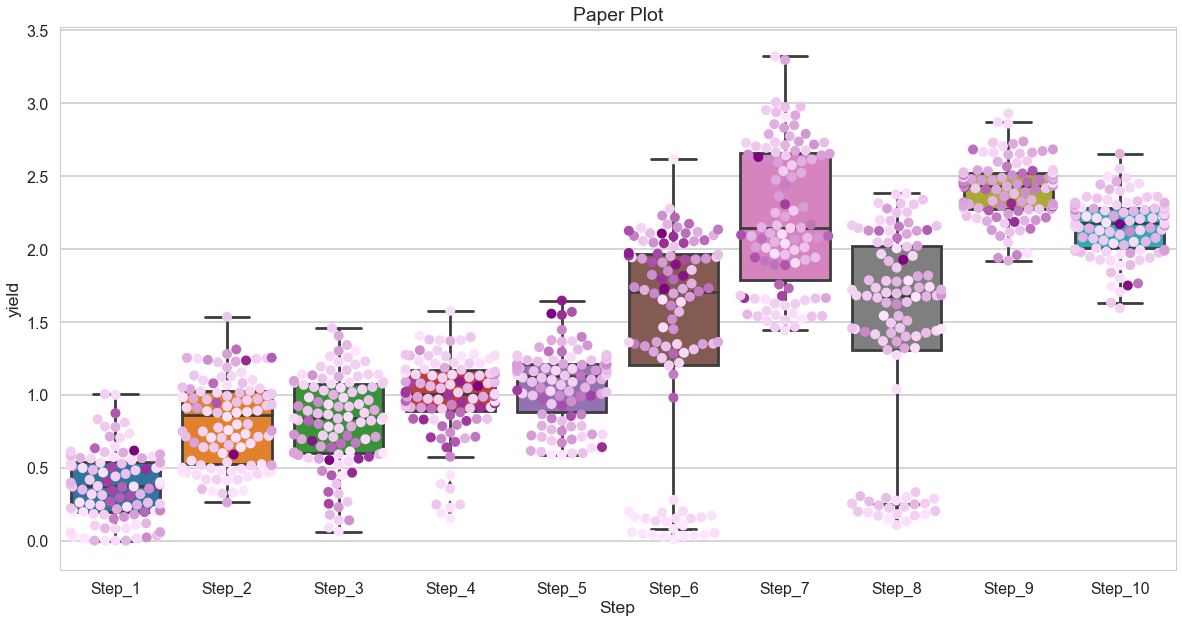

In [19]:
# Part 2: Plotting
boxplot(box_dataset, 'Step', 'yield', hue='yield_std', point_size = 5, title='Paper Plot')

## Active Learning

In [20]:
# Part 1: choose grid for our metabolite conc

# Allowed concentrations
allowed_conc ={
'nad': (0.033, 0.33),
'folinic_acid': (0.0068, 0.068),
'coa_conc': (0.026, 0.26),
'nucleo_mix': (0.15, 1.5),
'spermidine': (0.1, 1.0),
'pga': (3.0, 30.0),
'aa': (0.15, 1.5),
'trna': (0.02, 0.2),
'mg_gluta': (0.4, 4.0),
'camp': (0.075, 0.75),
'K_gluta': (8.0, 80.0)}

In [21]:
# Part 2: make a random input for our model
def random_input(allowed_conc, n=100, rounded=3, verbose=0):
    X_train = []
    for data_point in range(n):
        input_data = []
        if (data_point % 10000 == 0) and verbose:
            print(data_point)
        for key, value in allowed_conc.items():
            input_data.append(np.round(np.random.uniform(*value), rounded))
        X_train.append(input_data)

    X_train = np.array(X_train)
    return X_train

In [22]:
# define our model that will be trained by active learning
# same hyperparameter as Gold Standard model
regressor = xgb.XGBRegressor(
objective = 'reg:squarederror',
n_estimators = 500,
learning_rate = 0.01,
max_depth = 6,
min_child_weight = 1,
subsample = 0.8
)

In [24]:
def active_learning(regressor, gold_regressor, allowed_conc, test_size = 100, steps = 10, verbose=0):
    ## first step
    if verbose:
        print('step:  1')    
    # make first dataset
    X_train_1 = random_input(allowed_conc, test_size)
    
    # first fit
    regressor.fit(X_train_1, gold_regressor.predict(X_train_1))
    
    # save results
    result = pd.DataFrame(X_train_1)
    result['gold_yield'] = gold_regressor.predict(X_train_1)
    result['pred_yield'] = 0.0 # not available but choose 0.0 to avoid further error
    result['step'] = 'step_1'
    
    ## next steps loop
    for step in range(steps-1):
        if verbose>=2:
            print('step: ',step+2)
        # make i th dataset
        X_train_1_1 = random_input(allowed_conc, 100000)
        df_1 = pd.DataFrame(X_train_1_1)
        df_1['pred_yield'] = regressor.predict(X_train_1_1)
        df_1 = df_1.sort_values(['pred_yield'], ascending=False)
        X_train_2 = df_1.iloc[0:test_size,0:11].values
        
        # save and add results
        temp_result = pd.DataFrame(X_train_2)
        temp_result['gold_yield'] = gold_regressor.predict(X_train_2)
        temp_result['pred_yield'] = df_1.iloc[0:test_size,11:12].values
        temp_result['step'] = 'step_{}'.format(step+2)
        result = pd.concat([result, temp_result], ignore_index=True)
        
        # update and refit regressor
        regressor.fit(result.iloc[:,0:11].values, result.iloc[:,11].values)

    return result, regressor

In [98]:
regressor = xgb.XGBRegressor(
    objective = 'reg:squarederror',
    n_estimators = 500,
    learning_rate = 0.01,
    max_depth = 6,
    min_child_weight = 1,
    subsample = 0.8)
    
result, _ = active_learning(regressor, gold_regressor, allowed_conc, test_size=10, steps=3, verbose=2)

step:  1
step:  2
step:  3


In [100]:
result

,0,1,2,3,4,5,6,7,8,9,10,gold_yield,pred_yield,step
0,0.066,0.038,0.191,0.377,0.155,8.364,0.329,0.198,2.166,0.104,40.768,0.795756,0.000000,step_1
1,0.160,0.009,0.081,0.644,0.398,25.389,1.292,0.171,3.816,0.589,66.587,0.883276,0.000000,step_1
2,0.204,0.064,0.039,1.155,0.948,24.037,0.672,0.168,0.902,0.191,38.168,-0.141270,0.000000,step_1
3,0.072,0.063,0.116,1.357,0.944,8.221,0.158,0.046,0.468,0.198,76.422,0.272487,0.000000,step_1
4,0.151,0.049,0.133,1.398,0.474,3.728,1.371,0.118,1.975,0.273,17.389,1.024129,0.000000,step_1
5,0.176,0.026,0.149,1.202,0.464,5.932,1.486,0.047,1.285,0.613,53.558,1.023462,0.000000,step_1
6,0.245,0.008,0.187,0.479,0.663,28.206,1.463,0.102,3.195,0.628,62.125,0.265248,0.000000,step_1
7,0.033,0.034,0.103,1.113,0.970,6.035,1.095,0.171,3.784,0.398,53.966,0.528666,0.000000,step_1
8,0.163,0.010,0.100,1.294,0.710,16.731,0.969,0.190,1.915,0.258,74.858,0.790947,0.000000,step_1
9,0.088,0.060,0.256,0.152,0.924,11.889,1.135,0.049,0.659,0.158,41.236,-0.318292,0.000000,step_1


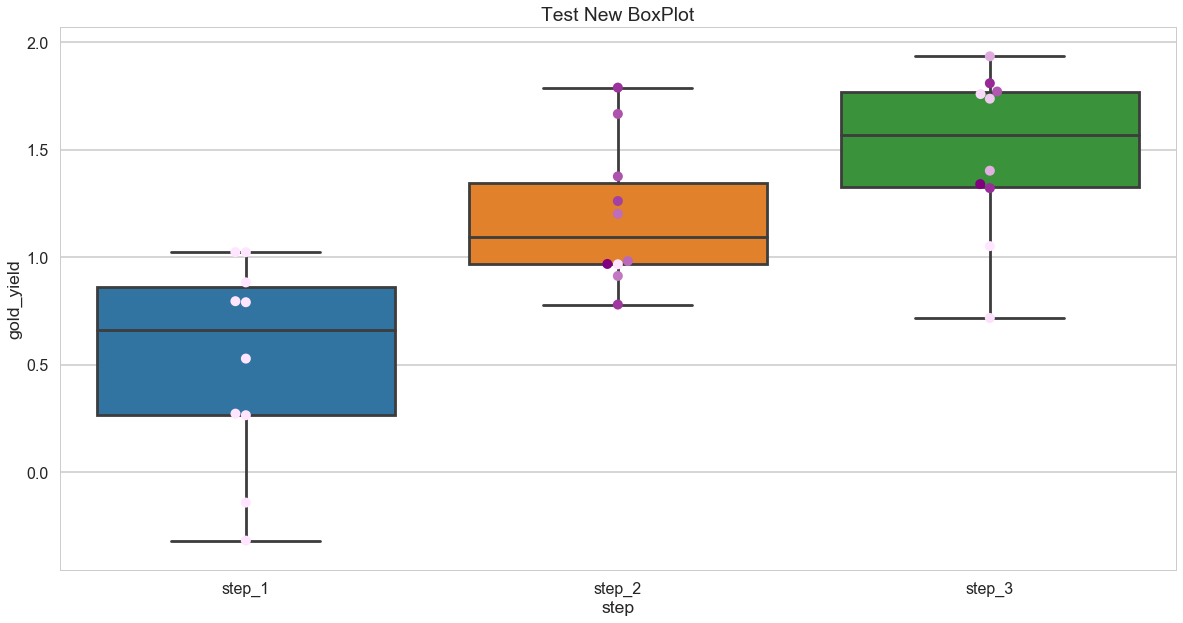

In [101]:
boxplot(data = result, group_name='step', quantity='gold_yield', hue = 'pred_yield', title = 'Test New BoxPlot', point_size = 5)

In [102]:
def bayesian_optimization(regressors_list,
                          gold_regressor,
                          allowed_conc,
                          exploitation=1, exploration=1, test_size=100, steps=10, verbose=0):
    ## first step
    if verbose:
        print('step:  1')    
    # make first dataset
    X_train_1 = random_input(allowed_conc, test_size)
    
    # first fit
    for regressor in regressors_list:
        regressor.fit(X_train_1, gold_regressor.predict(X_train_1))
    
    # save results
    result = pd.DataFrame(X_train_1)
    result['gold_yield'] = gold_regressor.predict(X_train_1)
    result['pred_yield'] = 0.0 # not available but choose 0.0 to avoid further error
    result['step'] = 'step_1'
    
    ## next steps loop
    for step in range(steps-1):
        if verbose>=2:
            print('step: ',step+2)
        # make i th dataset
        X_train_1_1 = random_input(allowed_conc, 100000)
        df_1 = pd.DataFrame(X_train_1_1)
        
        #upper Confidence Bound
        for index, regressor in enumerate(regressors_list):
            df_1['pred_yield_{}'.format(index)] = regressor.predict(X_train_1_1)
        
        df_1['regressors_std'] = df_1[[str(i) for i in df_1.columns if 'pred_yield' in str(i)]].std(axis=1)
        df_1['mean_vote'] = df_1[[str(i) for i in df_1.columns if 'pred_yield' in str(i)]].mean(axis=1)
        df_1['UCB'] = exploitation * df_1['mean_vote']+ exploration * df_1['regressors_std'] 
        df_1 = df_1.sort_values(['UCB'], ascending=False)
        X_train_2 = df_1.iloc[0:test_size,0:11].values
        
        # save and add results
        temp_result = pd.DataFrame(X_train_2)
        temp_result['gold_yield'] = gold_regressor.predict(X_train_2)
        #temp_result['pred_yield'] = df_1.iloc[0:test_size,11:12].values
        temp_result['pred_yield'] = df_1.mean_vote[0:test_size].values
        temp_result['step'] = 'step_{}'.format(step+2)
        result = pd.concat([result, temp_result], ignore_index=True)
        
        # update and refit regressor
        regressor.fit(result.iloc[:,0:11].values, result.iloc[:,11].values)

    return result, regressor

In [103]:
regressors_list = [xgb.XGBRegressor(
    objective = 'reg:squarederror',
    n_estimators = n,
    learning_rate = 0.01,
    max_depth = 6,
    min_child_weight = 1,
    subsample = 0.8) for n in (100, 200, 300, 400, 500)]


result, _ = bayesian_optimization(regressors_list, gold_regressor, allowed_conc, test_size=10, steps=3, verbose=2)

step:  1
step:  2
step:  3


In [104]:
result

,0,1,2,3,4,5,6,7,8,9,10,gold_yield,pred_yield,step
0,0.153,0.049,0.253,0.562,0.574,6.963,0.187,0.046,2.706,0.239,31.177,0.176037,0.000000,step_1
1,0.228,0.008,0.128,1.408,0.147,26.919,0.612,0.200,2.678,0.623,59.385,1.039364,0.000000,step_1
2,0.186,0.061,0.168,0.498,0.166,22.008,1.275,0.044,3.174,0.592,34.812,0.794731,0.000000,step_1
3,0.203,0.008,0.232,0.382,0.633,20.116,0.883,0.039,3.219,0.226,18.838,0.051628,0.000000,step_1
4,0.270,0.051,0.132,0.838,0.299,3.438,1.451,0.084,1.522,0.205,68.610,1.451622,0.000000,step_1
5,0.155,0.049,0.103,0.305,0.992,9.247,1.329,0.117,3.440,0.180,49.082,0.222713,0.000000,step_1
6,0.323,0.024,0.215,1.200,0.204,17.816,1.137,0.058,1.467,0.468,42.312,0.982464,0.000000,step_1
7,0.281,0.028,0.217,1.423,0.739,4.405,1.063,0.100,1.841,0.512,48.380,0.593786,0.000000,step_1
8,0.265,0.035,0.198,0.386,0.604,28.067,0.999,0.125,1.832,0.737,17.225,-0.440503,0.000000,step_1
9,0.242,0.019,0.123,1.371,0.878,5.382,0.494,0.121,0.585,0.582,38.596,0.026031,0.000000,step_1


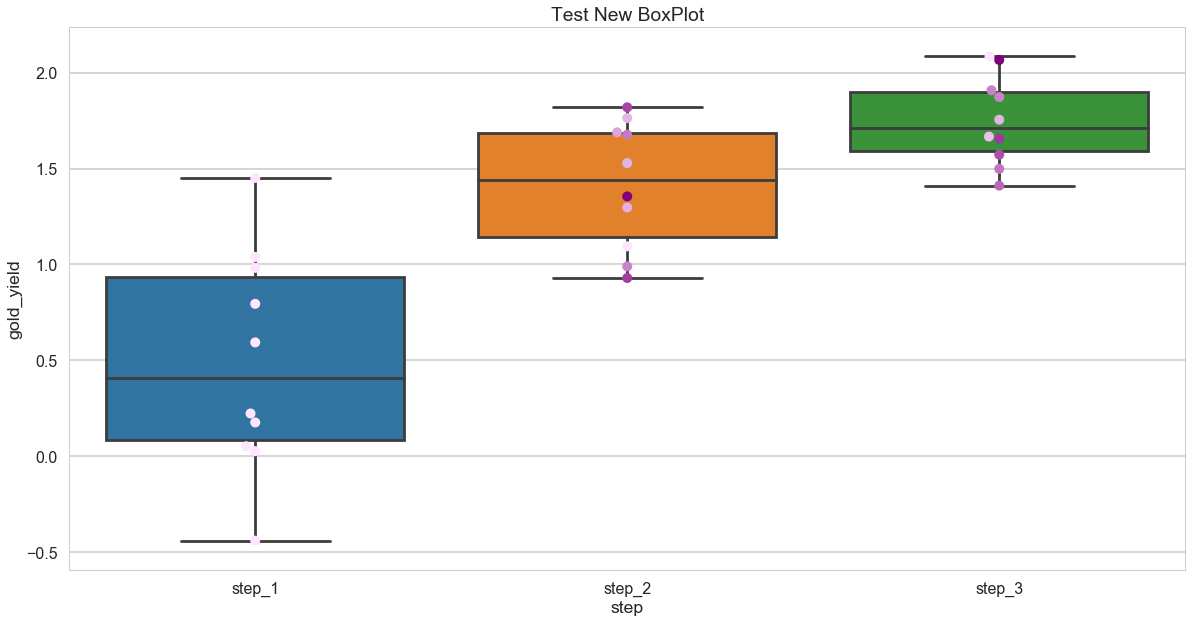

In [105]:
boxplot(data = result, group_name='step', quantity='gold_yield', hue = 'pred_yield', title = 'Test New BoxPlot', point_size = 5)

In [107]:
result_list_normal = []
result_list_ucb = []
for size in (3, 5, 10, 25, 100):
    # define our model that will be trained by active learning
    # same hyperparameter as Gold Standard model
    regressor = xgb.XGBRegressor(
    objective = 'reg:squarederror',
    n_estimators = 500,
    learning_rate = 0.01,
    max_depth = 6,
    min_child_weight = 1,
    subsample = 0.8)
    
    regressors_list = [xgb.XGBRegressor(
    objective = 'reg:squarederror',
    n_estimators = n,
    learning_rate = 0.01,
    max_depth = 6,
    min_child_weight = 1,
    subsample = 0.8) for n in (100, 200, 300, 400, 500)]

    result_temp, _ = active_learning(regressor, gold_regressor, allowed_conc, test_size=size, steps=10)
    result_list_normal.append(result_temp)
    
    result_temp, _ = bayesian_optimization(regressors_list, gold_regressor, allowed_conc, test_size=size, steps=10)
    result_list_ucb.append(result_temp)

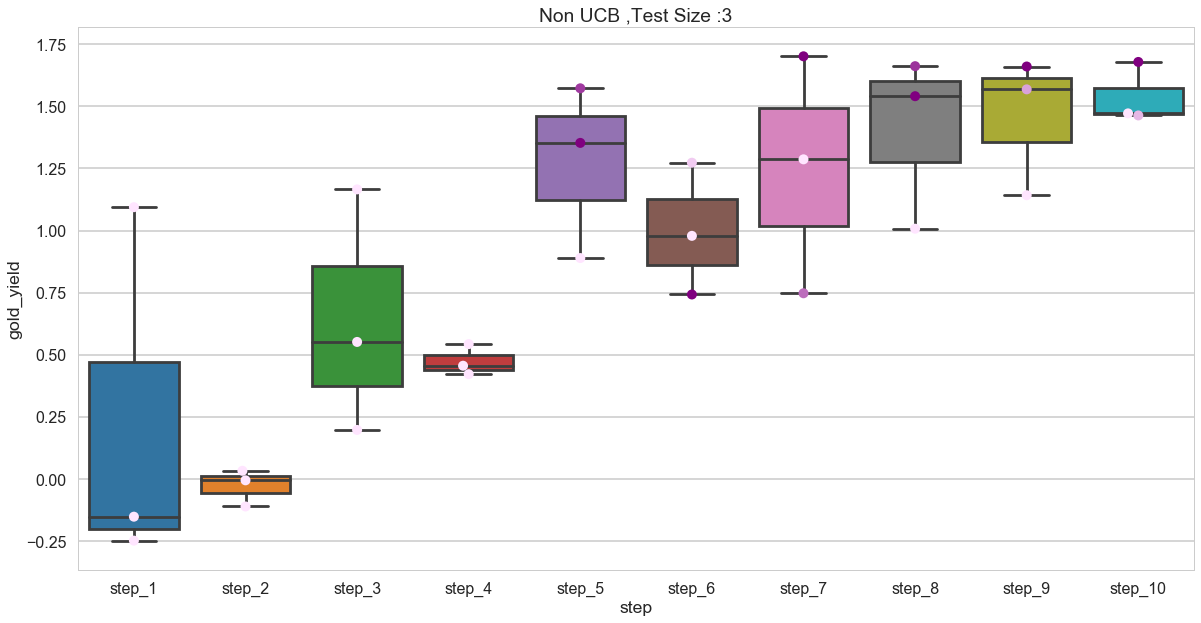

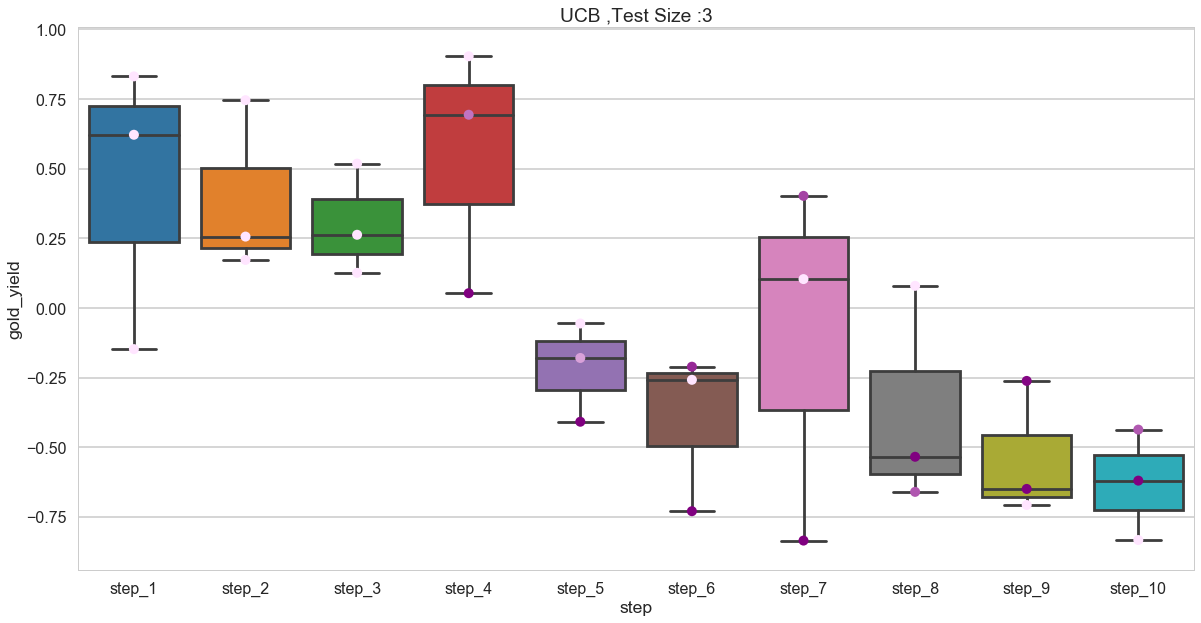

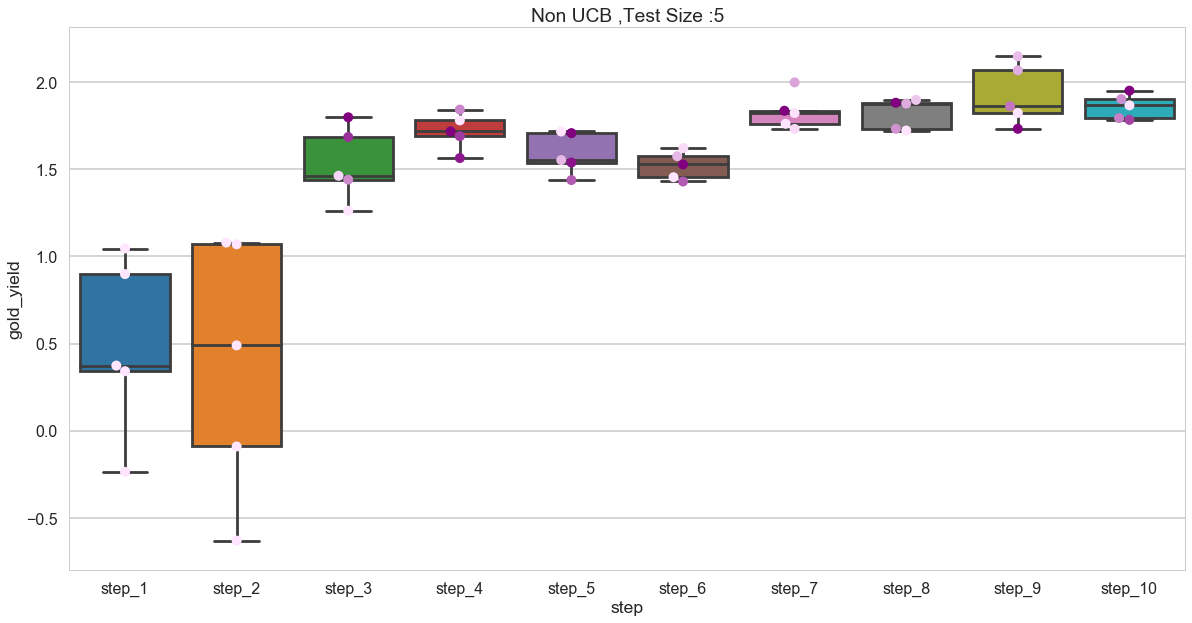

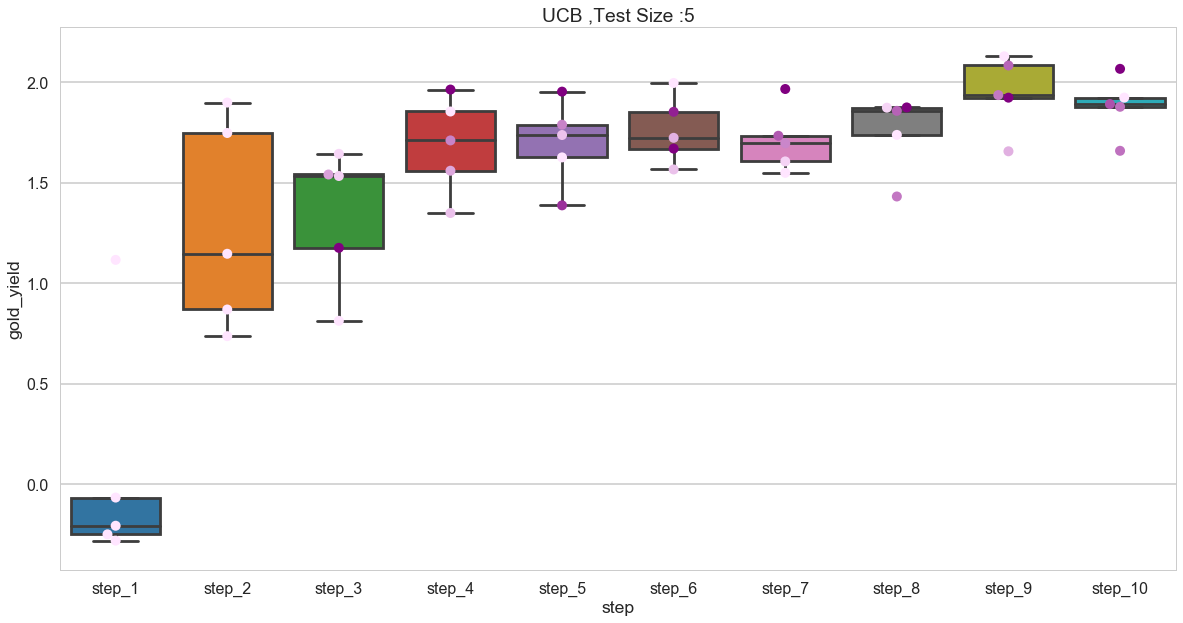

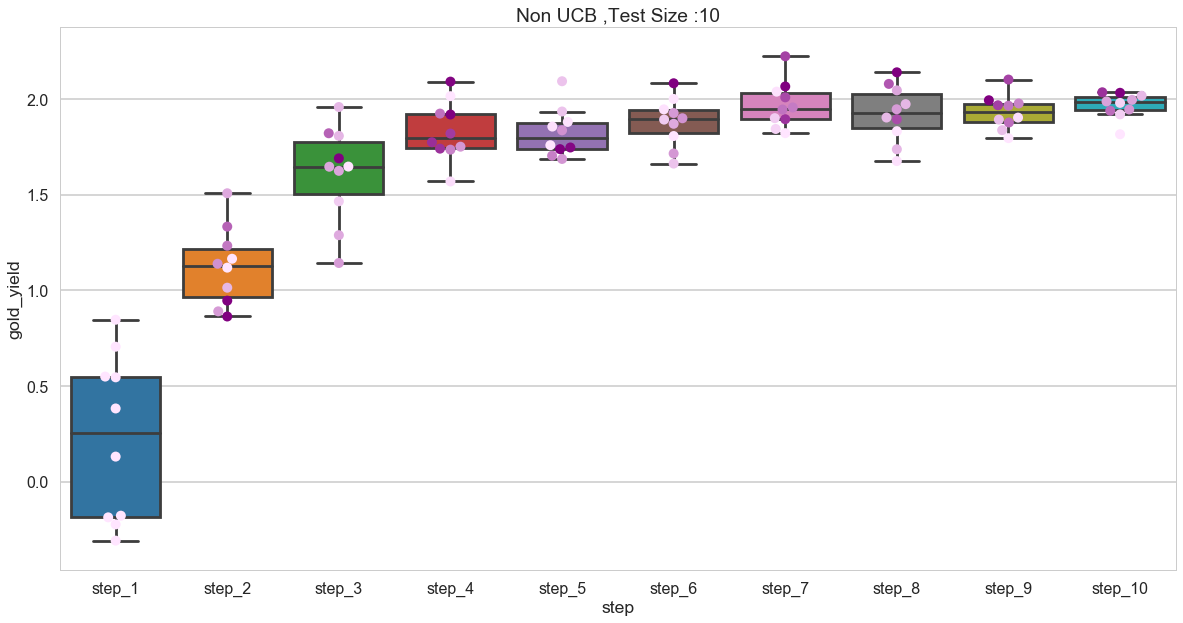

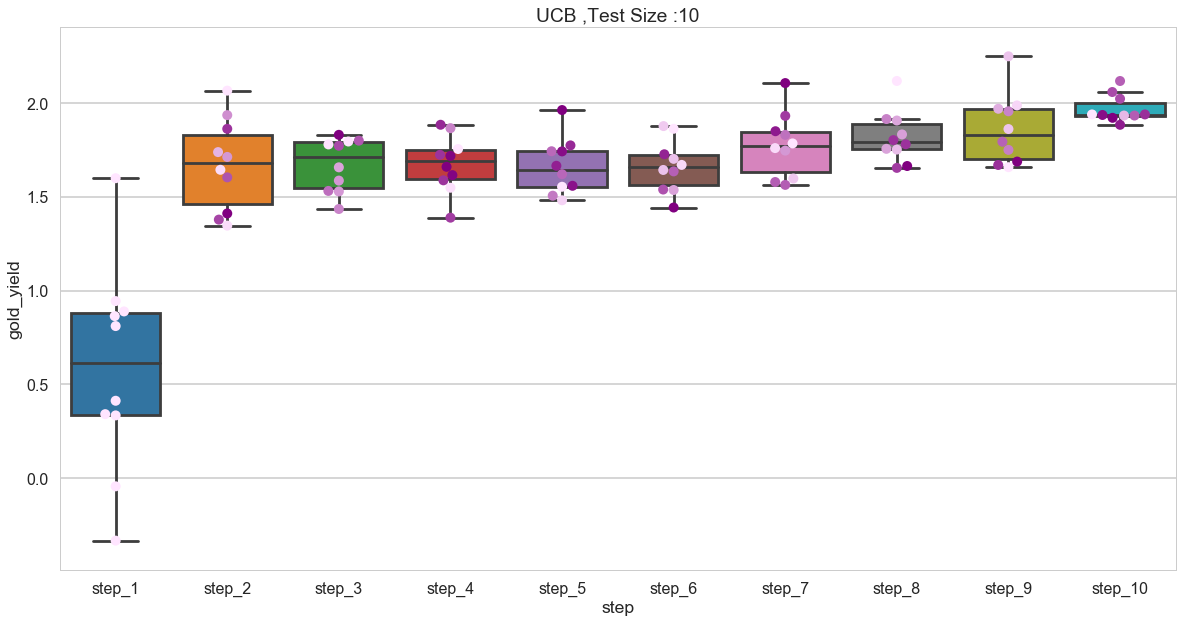

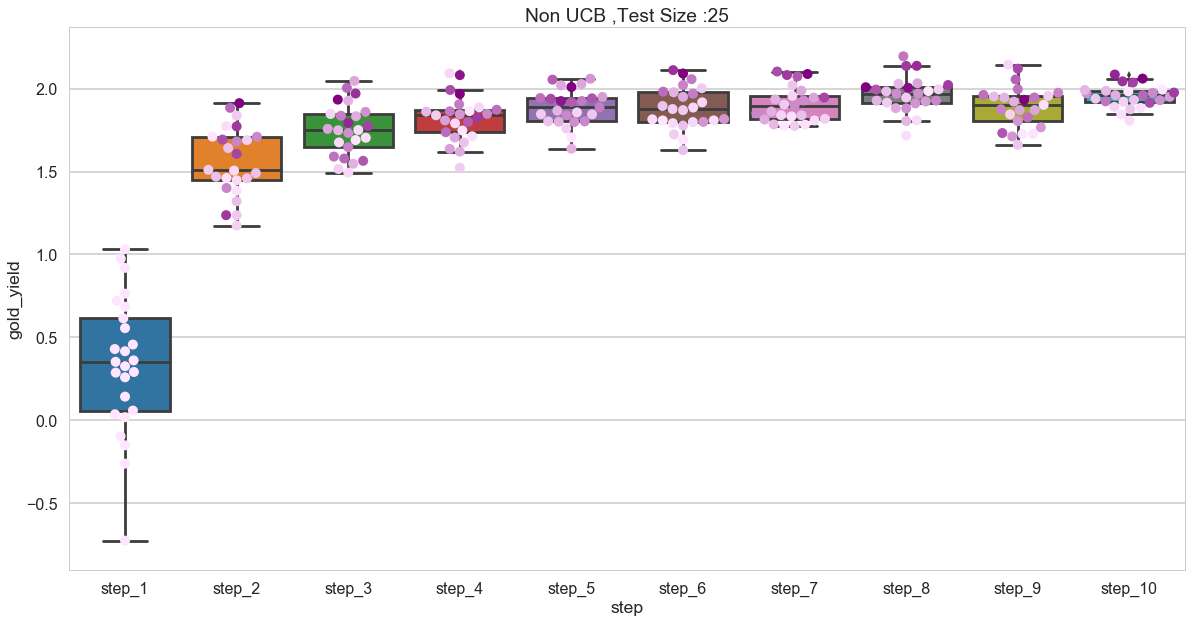

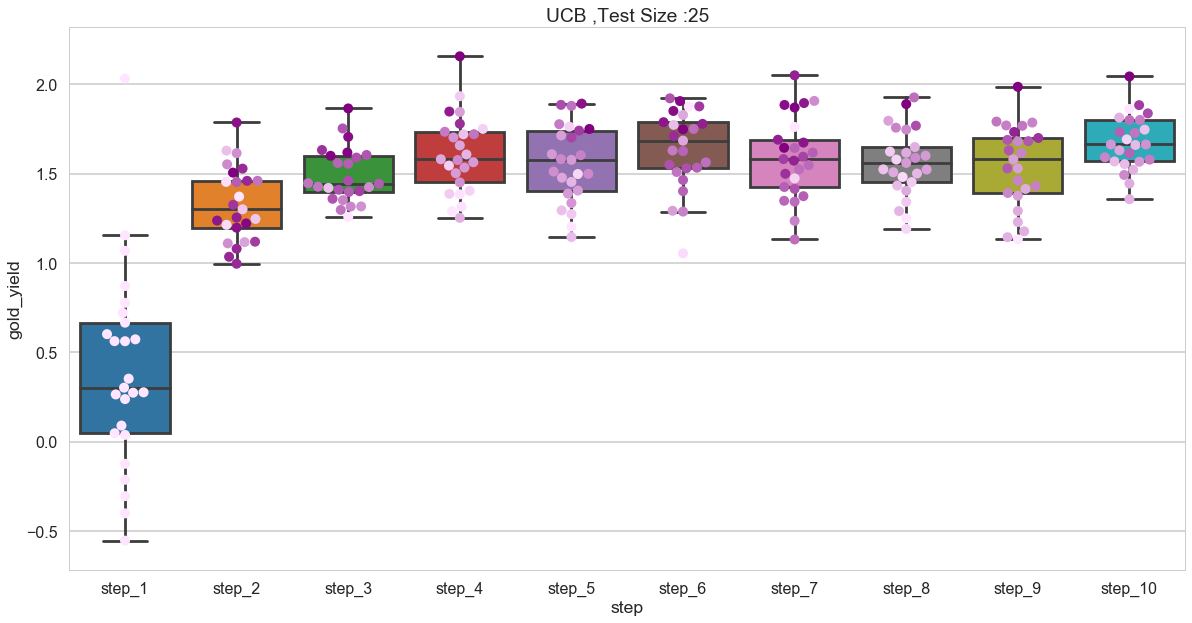

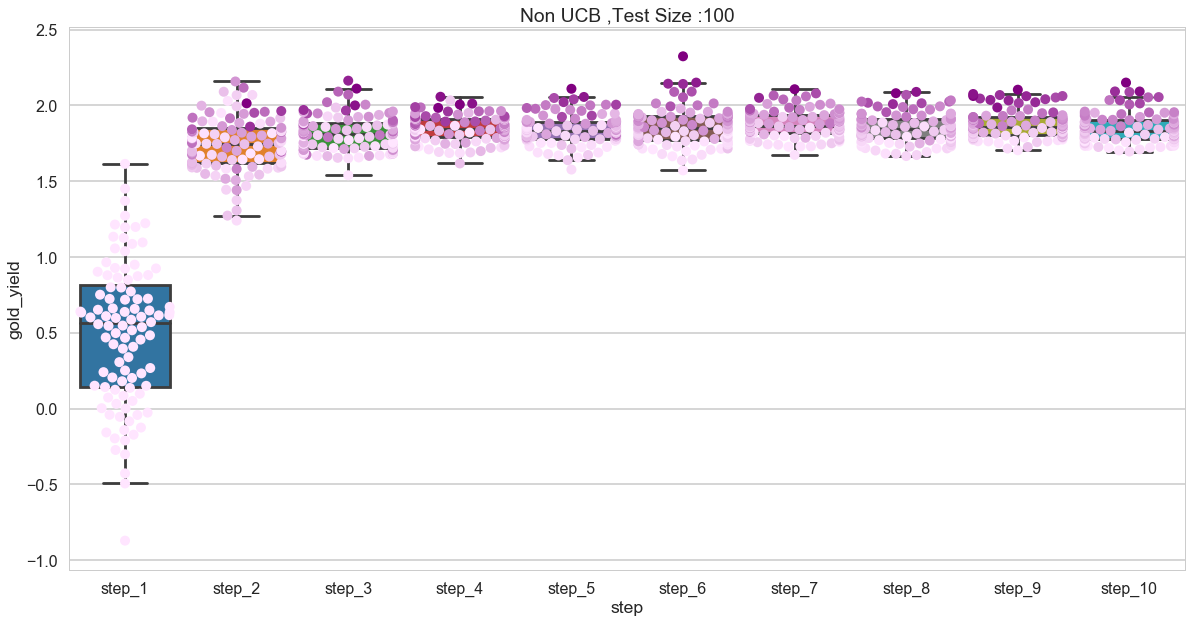

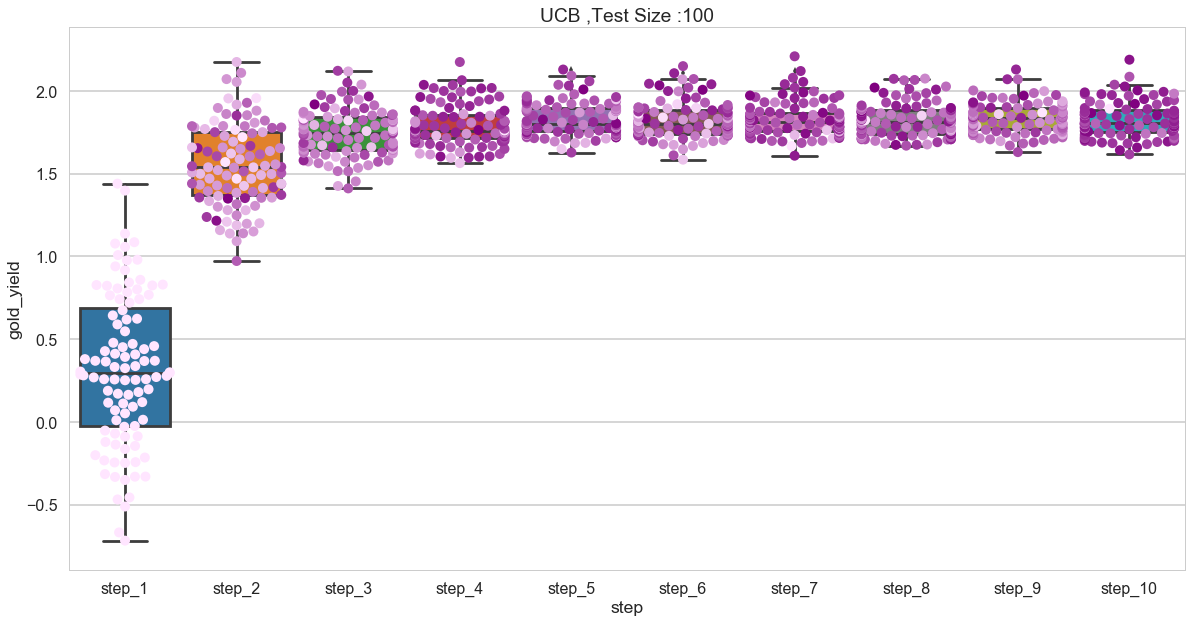

In [108]:
# Plotting
for i in range(5):
    boxplot(data = result_list_normal[i], group_name='step', quantity='gold_yield', hue = 'pred_yield', title='Non UCB ,Test Size :{}'.format((3, 5, 10, 25, 100)[i]),point_size=2)
    boxplot(data = result_list_ucb[i], group_name='step', quantity='gold_yield', hue = 'pred_yield', title='UCB ,Test Size :{}'.format((3, 5, 10, 25, 100)[i]),point_size=2)